Testing script for image augmentation

In [225]:
import random

import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation, RandomResizedCrop, ToPILImage
from torchvision.transforms.functional import invert, adjust_brightness, pil_to_tensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [135]:
transform = transforms.ToTensor()
train_kwargs = {'batch_size': 10, 'shuffle':True}
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, **train_kwargs)


In [136]:
device = 'cpu'
for batch, (x,y) in enumerate(train_loader):
    x,y = x.to(device), y.to(device)
    break

In [137]:
def denormalize(x):
    x = (x * 255)
    # x = x.reshape(28,28)

    return x

Test for rotation

In [94]:
rotate = RandomRotation(degrees=(45,60))
indices_to_rotate = random.sample(range(len(x)),2)

In [140]:
indices_to_rotate

[3, 1]

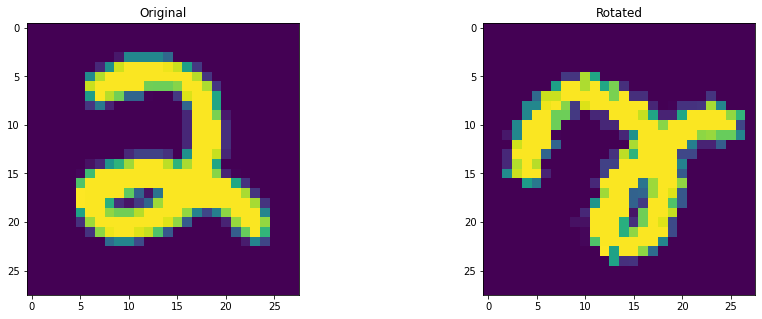

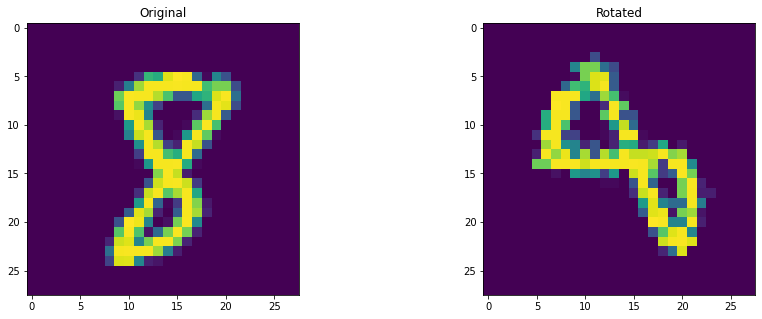

In [138]:
for i in range(len(x)):
    if i in indices_to_rotate:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axes[0].imshow(denormalize(x[i]).permute(1,2,0))
        axes[0].set(title = 'Original')
        x[i] = rotate(x[i])
        axes[1].imshow(denormalize(x[i]).permute(1,2,0))
        axes[1].set(title = 'Rotated')

Test for image inversion

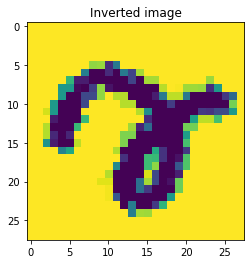

In [139]:
plt.imshow(denormalize(invert(x[1])).permute(1,2,0))
plt.title('Inverted image');

Test for lighting change

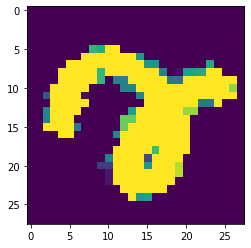

In [141]:
plt.imshow(denormalize(adjust_brightness(x[1],4.0)).permute(1,2,0))

Test for zooming in 

In [147]:
_,_,shape = next(iter(train_loader))[0][0].shape
shape

28

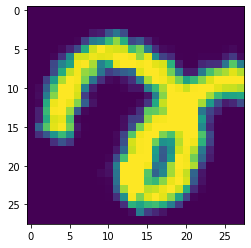

In [148]:
Crop = RandomResizedCrop((shape,shape),(0.2,0.8))
plt.imshow(denormalize(Crop(x[1])).permute(1,2,0))

Gaussian Noise Test

In [168]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.5):
        '''
        Reduced the std from 1 to 0.5 because the resultant gaussed image was unrecognizable to humans.
        '''
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [169]:
Gauss = AddGaussianNoise(0,0.5)
Gauss

AddGaussianNoise(mean=0, std=0.5)

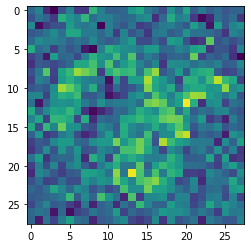

In [171]:
plt.imshow(denormalize(Gauss(x[1])).permute(1,2,0))

Add watermark

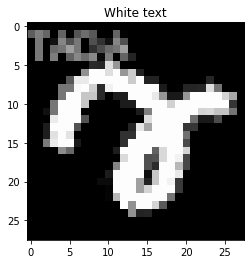

In [217]:
from PIL import ImageFont, ImageDraw

x_w = x[1].clone()
x_w = ToPILImage()(x[1].clone().data).convert('RGBA')
draw = ImageDraw.Draw(x_w)
font = ImageFont.truetype("/Library/fonts/Arial.ttf", 5)

draw.text((0, 0), "TADA", 
          (255, 255, 255), font=font)
x_w = pil_to_tensor(x_w)
plt.title("White text")
plt.imshow(x_w.permute(1,2,0))
